In [4]:
import re
import h5py
import pandas as pd
import numpy as np
import importlib
import os

import gvar
os.chdir('/home/gmoney/lqcd/lqcd_corr_analysis/')
from src.utilities.h5io import get_dsets

fit_params = 'tests/input_file/a071m170.py'
# sys.path.insert(0,'/Users/grantdb/lqcd/c51_corr_analysis')


ModuleNotFoundError: No module named 'utilities'

In [48]:
sys.path.append(os.path.dirname(os.path.abspath(fit_params)))
fp = importlib.import_module(
        fit_params.split('/')[-1].split('.py')[0])
data_dir = fp.file_params['data_dir']

In [49]:

dirs = os.listdir( data_dir )
cnf_abbr = [files.split(".ama.h5")[0] for files in dirs]
cnf_abbr = [cnf.replace('-','.') for cnf in cnf_abbr]
# cnf_abbr_ascend = {}
cnf_abbr_ascend = [cnf_.split('_')[1] for cnf_ in cnf_abbr]
cfg_abbr_sorted = np.sort(cnf_abbr_ascend,axis=None)
with open("cfg.txt","a") as f: 

    print(cfg_abbr_sorted.astype(int).tolist(),file=f)
data_file_list = list()
for dirpath,_,filenames in os.walk(data_dir):
    for f in filenames:
        data_file_list.append(os.path.abspath(os.path.join(dirpath, f)))
sorted_files = np.sort(data_file_list)
file = data_file_list[0]

In [85]:
h5f = h5py.File('./src/fitter/proton.h5','r')
# h5f_sp = h5py.File('proton_SP.h5','r')
# line = next(h5f)
# h5f = h5py.File('pion.h5','r')
string = '2pt/proton/src10.0_snk10.0/proton/AMA'
string_sp = '2pt/proton_SP/src10.0_snk10.0/proton/AMA'
string_tsep10 = '3pt_tsep10/'
ifil = h5f[string][:]
ifil_sp = h5f[string_sp][:]
import pandas as pd
# only need real part for 2pt correlators
_ifil = pd.DataFrame(ifil)['re'] 
_ifil_sp = pd.DataFrame(ifil_sp)['re'] 
corrs = {}
corrs['proton'] = _ifil.to_numpy()
corrs['proton_SP'] = _ifil_sp.to_numpy()
# corrs.columns
corrs
from prepare_data_lanl import *
Ncfg = corrs['proton'].shape[0]
bl = 9
ydata = {}
ydata['proton'] = np.reshape(corrs['proton'], (Ncfg//bl, bl))
ydata['proton_SP'] = np.reshape(corrs['proton_SP'], (Ncfg//bl, bl))
from prepare_data_lanl import *
ydata_out = bs_to_gvar(data=ydata, corr='proton',bs_N=100)
print(ydata_out)
# gv.dataset.avg_data(ydata['proton'])
import corr_functions as cf
Tags = ['proton','proton_SP']
c2 = {}
c2['proton'] = cf.C_2pt(tag='proton',ydata=ydata_out['proton'],skip_fastfit=False)
c2['proton_SP'] = cf.C_2pt(tag='proton_SP',ydata=ydata_out['proton_SP'],skip_fastfit=True)

c2_src = c2['proton']
c2_snk = c2['proton_SP']

c2_src.fastfit()


# ydata

32
{'proton': array([2.3(1.1)e-13, 2.1(1.0)e-13, 2.1(1.1)e-13, 2.2(1.3)e-13,
       2.2(1.3)e-13, 2.3(1.2)e-13, 2.3(1.1)e-13, 2.3(1.2)e-13,
       2.3(1.3)e-13], dtype=object), 'proton_SP': array([2.29(85)e-10, 2.25(83)e-10, 2.22(93)e-10, 2.2(1.0)e-10,
       2.2(1.1)e-10, 2.3(1.0)e-10, 2.29(89)e-10, 2.27(96)e-10,
       2.3(1.1)e-10], dtype=object)}


TypeError: 'NoneType' object is not callable

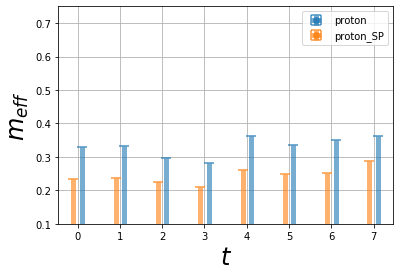

In [64]:
import matplotlib.pyplot as plt
import matplotlib
def plot_effective_mass(correlators_gv, t_plot_min = None, t_plot_max = None):
    if t_plot_min == None: t_plot_min = 0
    if t_plot_max == None: t_plot_max = correlators_gv['proton'].shape[0] - 1

    tau = +2
    effective_mass = gv.BufferDict()
    for key in correlators_gv.keys():
        effective_mass[key] = (1.0/tau) * np.log(correlators_gv[key] / np.roll(correlators_gv[key], -tau))
    t = np.arange(t_plot_min, t_plot_max)
    for j, key in enumerate(sorted(correlators_gv.keys())):
        y = gv.mean(effective_mass[key])[t]
        y_err = gv.sdev(effective_mass[key])[t]
        
        tp = t + 0.1 - j*0.2
        plt.errorbar(tp, y, xerr = 0.0, yerr=y_err, fmt='o', capsize=5.0,capthick=2.0, alpha=0.6, elinewidth=5.0, label=key)


    # Label dirac/smeared data
    plt.legend()
    plt.grid(True)
    plt.ylim(0.1, 0.75)
    plt.xlabel('$t$', fontsize = 24)
    plt.ylabel('$m_{eff}$', fontsize = 24)
    fit = plt.gcf()
    plt.close()
    return fit
plot_effective_mass(ydata_out)


In [59]:
threept_patterns = [
    "3pt",
    "_tsep(?P<tsep>[0-9]|[0-9]+)",  # must match `_tsep` and stores the following numbers (any length)
    "/NUCL_(?P<quark>U|D)",  # Store U or D in quark
    "_MIXED_NONREL",  # Not sure if this changes. Not stored for now
    "_l(?P<l>[0-9]+)",  # action parameters?
    "_g(?P<g>[0-15]+)",
    "/src(?P<src>[0-9\.]+)",  # Stores numbers + . to store decimals. Must escape .
    "_snk(?P<snk>[0-9\.]+)",  # Stores numbers + . to store decimals. Must escape .
    "/qz(?P<qz>[\+\-0-9]+)", 
    "_qy(?P<qy>[\+\-0-9]+)", 
    "_qx(?P<qx>[\+\-0-9]+)",
]

twopt_patterns = [
    "2pt",
    "/(?P<corr>pion|pion_SP|proton|proton_SP)",
    "(?P<cfg>E7.\w\_[0-9][0-9][0-9][0-9]+)\/"
]

for n in range(len(threept_patterns)):
    pattern = "".join(threept_patterns[:n+1])
    print(pattern)
#     match = re.match(pattern, string)
#     if not match:
#         print(pattern)
#         break

# if match:
#     print(match.groupdict())

3pt
3pt_tsep(?P<tsep>[0-9]|[0-9]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>[0-15]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>[0-15]+)/src(?P<src>[0-9\.]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>[0-15]+)/src(?P<src>[0-9\.]+)_snk(?P<snk>[0-9\.]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>[0-15]+)/src(?P<src>[0-9\.]+)_snk(?P<snk>[0-9\.]+)/qz(?P<qz>[\+\-0-9]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>[0-15]+)/src(?P<src>[0-9\.]+)_snk(?P<snk>[0-9\.]+)/qz(?P<qz>[\+\-0-9]+)_qy(?P<qy>[\+\-0-9]+)
3pt_tsep(?P<tsep>[0-9]|[0-9]+)/NUCL_(?P<quark>U|D)_MIXED_NONREL_l(?P<l>[0-9]+)_g(?P<g>

In [37]:
data_frames = []

with h5py.File(file, "r") as h5f:
    dsets = get_dsets(h5f)

    for key, dset in dsets.items():
        match = re.search(threept_patterns, key)
        if match:
            info = match.groupdict()

            # nucleon_parity = info.pop("parity").split("_")
            # info["nucleon"] = nucleon_parity[0]
            # info["parity"] = -1 if len(nucleon_parity) == 2 else 1
            
            # isospin = info.pop("isospin")
            # info["isospin"] = 1 if isospin == "UU" else -1            

            # current_key = key.replace("cfgs_srcs", "local_curr")
            # curr_dset = h5f[current_key]

            # cfgs = dset[:, 0]
            # corr = (
            #     curr_dset[()].real if info["current"] in ["V4"] else curr_dset[()].imag
            # )
            # ts = range(corr.shape[-1])

            # tmp_df = (
            #     pd.DataFrame(index=cfgs, columns=ts, data=corr)
            #     .unstack()
            #     .reset_index()
            #     .rename(columns={"level_0": "t", "level_1": "cfg", 0: "corr"})
            # )
            # for key, val in info.items():
            #     tmp_df[key] = val
            # data_frames.append(tmp_df.astype({"tsep": int}))


[2022-09-05 15:15:00,131|lqcd correlator analysis@INFO] Locating all dsets of h5 file `/home/gbradley/c51_corr_analysis/tests/data/E7/E7-a_1716.ama.h5`


TypeError: unhashable type: 'list'